In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load the fabner dataset
ds = load_dataset("DFKI-SLT/fabner", "fabner")
print(ds)

# Load sensor data
sensor_data = pd.read_csv(r"C:\Users\ishir\Enhancing-Predictive-Maintenance-with-Multi-Source-Data-Integration\sensor_dataset\data.csv")
print(sensor_data.head())

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 9435
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2183
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2064
    })
})
   footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
0         0         7   7    1   6    6  36   3            1     1
1       190         1   3    3   5    1  20   4            1     0
2        31         7   2    2   6    1  24   6            1     0
3        83         4   3    4   5    1  28   6            1     0
4       640         7   5    6   4    0  68   6            1     0


In [3]:
# Extract sentences and labels from the fabner dataset
def extract_fabner_data(dataset):
    sentences = []
    labels = []
    
    for example in dataset['train']:
        sentences.append(example['tokens'])
        labels.append(example['ner_tags'])
    
    return sentences, labels

# Extract data
sentences, labels = extract_fabner_data(ds)
print(sentences[:5], labels[:5])

[['Revealed', 'the', 'location-specific', 'flow', 'patterns', 'and', 'quantified', 'the', 'speeds', 'of', 'various', 'types', 'of', 'flow', '.'], ['Reconstructed', 'three-dimensional', 'flow', 'pattern', 'under', 'both', 'conduction-mode', 'melting', 'and', 'depression-mode', 'melting', '.'], ['Experimentally', 'analyzed', 'the', 'prevailing', 'physical', 'processes', 'at', 'different', 'locations', 'in', 'the', 'melt', 'pool', '.'], ['Melt', 'flow', 'plays', 'a', 'critical', 'role', 'in', 'laser', 'metal', 'additive', 'manufacturing', ',', 'yet', 'the', 'melt', 'flow', 'behavior', 'within', 'the', 'melt', 'pool', 'has', 'never', 'been', 'explicitly', 'presented', '.'], ['Here', ',', 'we', 'report', 'in-situ', 'characterization', 'of', 'melt-flow', 'dynamics', 'in', 'every', 'location', 'of', 'the', 'entire', 'melt', 'pool', 'in', 'laser', 'metal', 'additive', 'manufacturing', 'by', 'populous', 'and', 'uniformly', 'dispersed', 'micro-tracers', 'through', 'in-situ', 'high-resolution', '

In [61]:
# Check lengths
sensor_length = len(sensor_data)
fabner_length = len(sentences)
min_length = min(sensor_length, fabner_length)  # Use the smaller length

print(f"Sensor Data Length: {sensor_length}, Fabner Data Length: {fabner_length}")
print(f"Using min length: {min_length}")

# Ensure the selected sensor column is valid
sensor_column = sensor_data.columns[1]  # Adjust if needed

# Combine datasets with matching lengths
combined_data = pd.DataFrame({
    'sensor_data': sensor_data[sensor_column].values[:min_length],  
    'fabner_sentences': [' '.join(sentence) for sentence in sentences[:min_length]],
    'fabner_labels': labels[:min_length]
})

print(combined_data.head())

Sensor Data Length: 944, Fabner Data Length: 9435
Using min length: 944


ValueError: All arrays must be of the same length

In [6]:
# Tokenization and encoding for NER
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_labels(sentences, labels):
    input_ids = []
    attention_masks = []
    label_ids = []

    for sentence, label in zip(sentences, labels):
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        label_ids.append(label)

    return torch.cat(input_ids), torch.cat(attention_masks), label_ids

input_ids, attention_masks, label_ids = encode_labels(sentences, labels)

In [7]:
# Create a dataset class for time-series data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Debug: Check available columns
print("Available columns:", combined_data.columns)

# Use 'fabner_labels' instead of 'failure' if appropriate
target_column = 'fabner_labels' if 'fabner_labels' in combined_data.columns else None

if target_column:
    y = combined_data[target_column].values
else:
    raise KeyError(f"Target column not found. Available columns: {combined_data.columns}")

# Drop only relevant columns
X = combined_data.drop(['fabner_sentences', 'fabner_labels'], axis=1).values  # Keep only numeric sensor data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Available columns: Index(['sensor_data', 'fabner_sentences', 'fabner_labels'], dtype='object')


In [8]:
from torch.nn.utils.rnn import pad_sequence

class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=128):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = str(self.data[idx])  # Convert numeric sensor data to string
        label = self.labels[idx]

        encoded_dict = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        input_ids = encoded_dict["input_ids"].squeeze(0)
        attention_mask = encoded_dict["attention_mask"].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)


def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    attention_masks = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    # Pad sequences to the same length
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # -100 for ignored tokens in CrossEntropyLoss

    return input_ids, attention_masks, labels

# Create DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train, tokenizer)
test_dataset = TimeSeriesDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print("Input shape:", input_ids.shape)
    print("Attention mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)
    break

Input shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Labels shape: torch.Size([32, 51])


In [9]:
# Define the BERT model for token classification
class NERModel(nn.Module):
    def __init__(self, num_labels):
        super(NERModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.logits

# Initialize model
num_labels = len(set([label for sublist in labels for label in sublist]))  # Adjust based on your labels
model = NERModel(num_labels=num_labels)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import torch.nn as nn

# Set up the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding tokens

# Training loop
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch in train_loader:
        input_ids, attention_mask, labels = batch

        # Ensure labels are the correct shape
        labels = labels.view(-1)  # Flatten labels
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        # Ensure outputs match expected shape (batch_size * seq_length, num_labels)
        batch_size, seq_length, num_labels = outputs.shape

        # Flatten outputs to match labels
        outputs = outputs.view(-1, num_labels)

        # Ensure label length matches output length
        if labels.shape[0] != outputs.shape[0]:
            min_len = min(labels.shape[0], outputs.shape[0])
            labels = labels[:min_len]
            outputs = outputs[:min_len]

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 3.1099
Epoch [2/10], Loss: 1.9822
Epoch [3/10], Loss: 1.7527
Epoch [4/10], Loss: 1.6096
Epoch [5/10], Loss: 1.5106
Epoch [6/10], Loss: 1.4643
Epoch [7/10], Loss: 1.4290
Epoch [8/10], Loss: 1.4178
Epoch [9/10], Loss: 1.3973
Epoch [10/10], Loss: 1.3902


Model Accuracy: 0.8307


ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of labels (2).

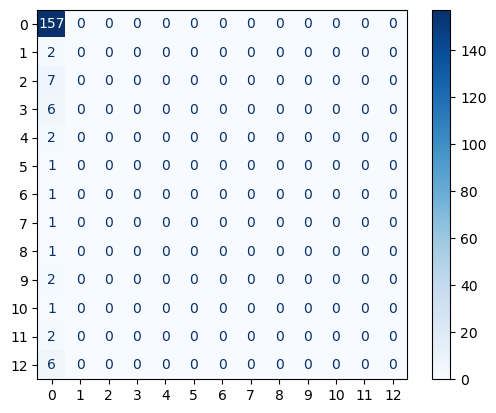

In [29]:
from sklearn.metrics import accuracy_score

# Set model to evaluation mode
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        # Ensure labels are properly formatted
        labels = labels.cpu().numpy()

        # If labels are not 1D, flatten them
        if labels.ndim > 1:
            labels = labels[:, 0]  # Select the first token/sequence label

        outputs = model(input_ids, attention_mask)

        # If output has 3D shape (batch_size, seq_len, num_classes), take first token's prediction
        if outputs.dim() == 3:
            predicted = torch.argmax(outputs, dim=-1)[:, 0]
        else:
            predicted = torch.argmax(outputs, dim=-1)

        # Move to CPU and convert to NumPy
        predicted = predicted.cpu().numpy()

        # Append processed labels and predictions
        y_pred.extend(predicted)
        y_true.extend(labels)

# Convert lists to NumPy arrays
y_true = np.array(y_true, dtype=np.int32)
y_pred = np.array(y_pred, dtype=np.int32)

# Ensure matching lengths
assert len(y_true) == len(y_pred), f"Mismatch: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})"

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

#print(y_true.shape)
#print(y_pred.shape)
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

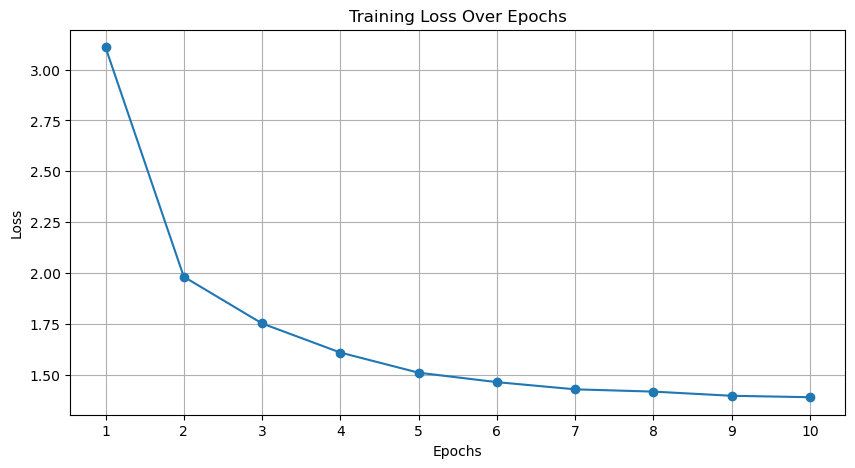

In [15]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()